In [1]:
# -*- coding: utf-8 -*-
import collections
import math
import os
import numpy as np
import random
from six.moves import xrange
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import tensorflow as tf
if tf.__version__[0] == '2':
    # Using TensorFlow 1.x to train our word2vec
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior()
%matplotlib inline  

In [2]:
data_folder  = "../input/109-1-ntut-dl-app-hw2"
filename   = "tag_list.txt"  # Hashtag list
vocabulary_size = 990

In [3]:
batch_size     = 128
embedding_size = 64       # Dimension of the embedding vector.
skip_window    = 1         # How many words to consider left and right.
num_skips      = 2         # How many times to reuse an input 

In [4]:
# Random validation set to sample nearest neighbors.
valid_size     = 32        # Random set of words to evaluate similarity 
valid_window   = 200       # Only pick validation samples in the top 200
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

In [5]:
file_path   = os.path.join(data_folder, filename)
with open(file_path, 'r', encoding="utf-8") as f:
    words = f.read().split()

In [6]:
words

['sea',
 'instapic',
 'instagram',
 'trip',
 'travel',
 'sea',
 'sea',
 'love',
 'beach',
 'sea',
 'trip',
 'island',
 'japan',
 'sun',
 'sand',
 'sea',
 'sky',
 'friend',
 'beach',
 'thailand',
 'trip',
 'adventure',
 'vsco',
 'vscocam',
 'blue',
 'bluesky',
 'sea',
 'nature',
 'naturelovers',
 'church',
 'road',
 'nikon',
 'photograph',
 'sea',
 'beach',
 'beach',
 'sea',
 'spring',
 'wild',
 'top',
 'sunday',
 'ocean',
 'sea',
 'portrait',
 'mylove',
 'beach',
 'wave',
 'sun',
 'happy',
 'holiday',
 'love',
 'nature',
 'sea',
 'beach',
 'germany',
 'home',
 'travel',
 'joy',
 'nofilter',
 'water',
 'amazing',
 'pictureoftheday',
 'beach',
 'sea',
 'crazy',
 'brasil',
 'surf',
 'surfing',
 'indonesia',
 'nature',
 'beach',
 'awesome',
 'sea',
 'traveler',
 'adventure',
 'sea',
 'beach',
 'vacation',
 'holiday',
 'look',
 'place',
 'moment',
 'sand',
 'tagsforlikes',
 'dance',
 'sweet',
 'sea',
 'photooftheday',
 'sunset',
 'sea',
 'sun',
 'italy',
 'light',
 'sky',
 'sunday',
 'frien

In [7]:
word_count = [['UNK', -1]] 
word_count.extend(collections.Counter(words)
             .most_common(vocabulary_size - 1)) # -1 is for UNK 
print ("%s" % (word_count[0:10]))

[['UNK', -1], ('love', 5892), ('friend', 3646), ('beach', 3025), ('family', 2966), ('yellow', 2667), ('girl', 2614), ('fashion', 2371), ('nike', 2253), ('snow', 2212)]


In [8]:
# Create word -> wordID dictionary
dictionary = dict() 
for word, _ in word_count:
    dictionary[word] = len(dictionary)

# Create reverse dictionary (wordID -> word)
reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))

In [9]:
# Convert word into wordID, and count unused words (UNK)
data = list()
unk_count = 0
for word in words:
    if word in dictionary:
        index = dictionary[word]
    else:
        index = 0  # dictionary['UNK']
        unk_count += 1
    data.append(index)
word_count[0][1] = unk_count
# del words  # Hint to reduce memory.

In [10]:
print ("Most common words (+UNK) are: %s" % (word_count[:10]))

Most common words (+UNK) are: [['UNK', 37], ('love', 5892), ('friend', 3646), ('beach', 3025), ('family', 2966), ('yellow', 2667), ('girl', 2614), ('fashion', 2371), ('nike', 2253), ('snow', 2212)]


In [11]:
print ("Sample data corresponds to\n__________________")
for i in range(10):
    print ("%d->%s" % (data[i], reverse_dictionary[data[i]]))

Sample data corresponds to
__________________
33->sea
90->instapic
60->instagram
144->trip
64->travel
33->sea
33->sea
1->love
3->beach
33->sea


In [12]:
# Data batch generator
data_index = 0
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch  = np.ndarray(shape=(batch_size),    dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips): # '//' makes the result an integer, e.g., 7//3 = 2
        target = skip_window
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [13]:
# Construct the word2vec model 
train_inputs   = tf.placeholder(tf.int32, shape=[batch_size])   
train_labels   = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset  = tf.constant(valid_examples, dtype=tf.int32)

# Look up embeddings for inputs. (vocabulary_size = 50,000)
with tf.variable_scope("EMBEDDING"):
    with tf.device('/cpu:0'):
        embeddings = tf.Variable(
            tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)
    
# Construct the variables for the NCE loss
with tf.variable_scope("NCE_WEIGHT"):
    nce_weights = tf.Variable(
                        tf.truncated_normal([vocabulary_size, embedding_size],
                        stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

In [14]:
with tf.device('/cpu:0'):
    # Loss function 
    num_sampled = 64        # Number of negative examples to sample. 
    
    loss = tf.reduce_mean(
                 tf.nn.nce_loss(weights=nce_weights,
                 biases=nce_biases,
                 labels=train_labels,
                 inputs=embed,
                 num_sampled=num_sampled,
                 num_classes=vocabulary_size))

    # Optimizer
    optm = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
    
    # Similarity measure (important)
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    siml = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)


In [15]:
print(normalized_embeddings.shape)

(990, 64)


In [16]:
# Train! 
sess = tf.Session()
sess.run(tf.initialize_all_variables())
#summary_writer = tf.summary.FileWriter('./w2v_train', graph=sess.graph)
average_loss = 0

num_steps = 10001
for iter in xrange(num_steps):
    batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
    feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}
    _, loss_val = sess.run([optm, loss], feed_dict=feed_dict)
    average_loss += loss_val
    
    if iter % 2000 == 0:
        average_loss /= 2000
        print ("Average loss at step %d is %.3f" % (iter, average_loss)) 
    
    if iter % 10000 == 0:
        siml_val = sess.run(siml)
        for i in xrange(valid_size): # Among valid set 
            valid_word = reverse_dictionary[valid_examples[i]]
            top_k = 6 # number of nearest neighbors
            nearest = (-siml_val[i, :]).argsort()[1:top_k+1]
            log_str = "Nearest to '%s':" % valid_word
            for k in xrange(top_k):
                close_word = reverse_dictionary[nearest[k]] 
                log_str = "%s '%s'," % (log_str, close_word)
            print(log_str) 
            
# Final embeding 
final_embeddings = sess.run(normalized_embeddings)

Average loss at step 0 is 0.070
Nearest to 'tbt': 'jacket', 'body', 'awesome', 'lovely', 'tattoo', 'together',
Nearest to 'photographer': 'bikini', 'cleaneating', 'magazine', 'artistic', 'wild', 'gift',
Nearest to 'bestfriend': 'strong', 'poland', 'gold', 'accessory', 'foodphotography', 'awake',
Nearest to 'relax': 'bed', 'curl', 'polishboy', 'artistic', 'creative', 'gold',
Nearest to 'wedding': 'ootd', 'air', 'hashtag', 'guitar', 'nail', 'sfs',
Nearest to 'instagood': 'wine', 'fresh', 'tgif', 'cupcake', 'weird', 'scene',
Nearest to 'tired': 'twilight', 'kik', 'ink', 'food', 'chef', 'nyc',
Nearest to 'foodie': 'explore', 'random', 'fly', 'couple', 'instafit', 'green',
Nearest to 'lunch': 'outfit', 'season', 'amor', 'cloudporn', 'sorry', 'star',
Nearest to 'girl': 'scenery', 'braid', 'red', 'tourist', 'creative', 'cloud',
Nearest to 'party': 'child', 'catsofinstagram', 'puppylove', 'autumn', 'night', 'selfienation',
Nearest to 'animal': 'sweet', 'justinbieber', 'ready', 'trip', 'blonde'

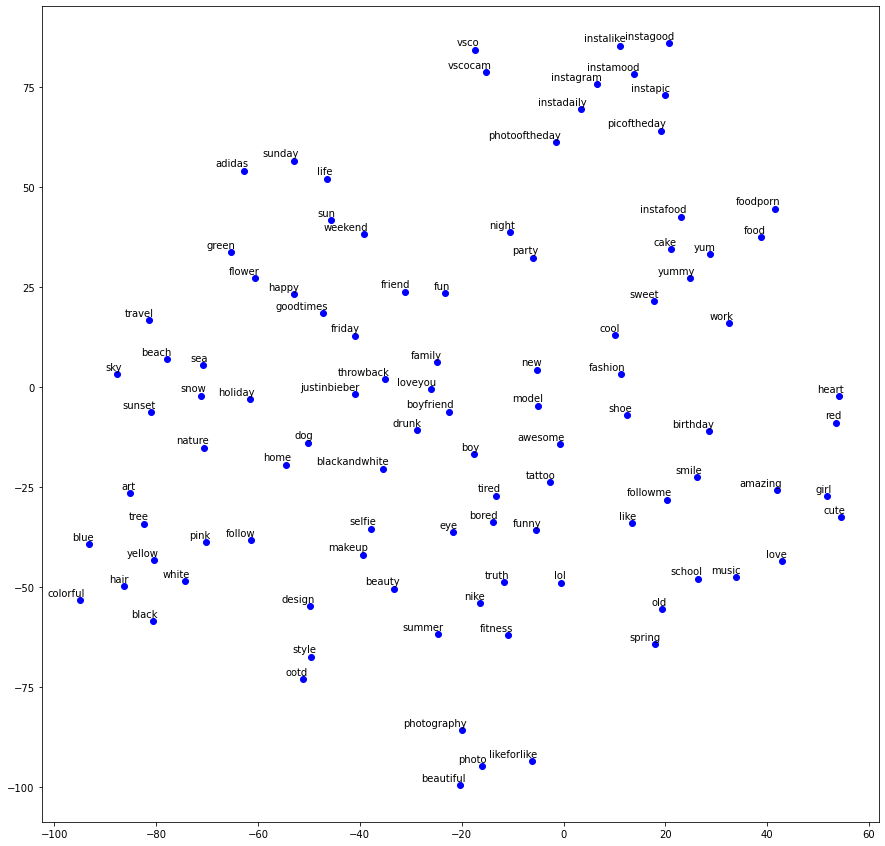

In [17]:
num_points = 100
tsne = TSNE(perplexity=10, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        plt.scatter(x, y, color=['blue'])
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    plt.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

In [18]:
# Save only Numpy matrices to 'word2vec.npz'
np.savez(filename[0:-4] +'_word2vec_' + str(embedding_size), word_count=word_count, dictionary=dictionary, reverse_dictionary=reverse_dictionary, word_embeddings=final_embeddings)

In [19]:
# Test numpy word2vectors
K = 10
target = 'drunk'
scores = final_embeddings[dictionary[target]].dot(final_embeddings.transpose())
scores = scores / np.linalg.norm(final_embeddings, axis=1)
k_neighbors = (-scores).argsort()[0:K+1]  

print('The nearest neighbors of', target, 'are:')
for k in k_neighbors:
    print(reverse_dictionary[k], ' ', scores[k])

The nearest neighbors of drunk are:
drunk   1.0
boyfriend   0.59676415
loveyou   0.582648
god   0.5575862
truth   0.4991513
throwback   0.49766782
sister   0.49743262
skylovers   0.49612212
goodtimes   0.47913384
friend   0.47507575
happy   0.47504866


In [20]:
# (Optional) You can download the embedding vectors and upload to projector.tensorflow.org
out_v = open('vecs.tsv', 'w', encoding='utf-8')
out_m = open('meta.tsv', 'w', encoding='utf-8')
for num, word in enumerate(dictionary):
  vec = final_embeddings[num] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

from IPython.display import FileLink
FileLink('vecs.tsv')

/kaggle/working/vecs.tsv

In [21]:
from IPython.display import FileLink
FileLink('meta.tsv')

/kaggle/working/meta.tsv

In [22]:
# Download your word embedding vectors
from IPython.display import FileLink
FileLink(filename[0:-4] +'_word2vec_' + str(embedding_size) + '.npz')

/kaggle/working/tag_list_word2vec_64.npz

In [23]:
import sys
sys.path.append(data_folder) # For importing utiliy.py

import keras
import numpy as np
from utility import *

from keras import models, layers, Model

In [24]:
IMAGE_FEAT_FILE = data_folder + '/harrison_features.npz'
#embedding_size = 64
TAG2VEC_FILE = 'tag_list_word2vec_' + str(embedding_size) + '.npz'
MODEL_NAME = 'im_hashtag_model.h5'

In [25]:
# Load Hashtag-to-Vector file
from packaging import version
t2v_data = None
if version.parse(np.__version__) > version.parse("1.16.2"):
    t2v_data = np.load(TAG2VEC_FILE, allow_pickle=True) # word_count, dictionary, reverse_dictionary, word_embeddings
else:
    t2v_data = np.load(TAG2VEC_FILE) # word_count, dictionary, reverse_dictionary, word_embeddings
    
tag_dictionary = t2v_data['dictionary'].tolist()
tag_reverse_dict = t2v_data['reverse_dictionary'].tolist()
tag_embeddings = t2v_data['word_embeddings']

In [26]:
# Load ImageNet features
feat_data = np.load(IMAGE_FEAT_FILE)
imnet_fc_feats = feat_data['imagenet_fc_layers']
place_fc_feats = feat_data['places365_fc_layers']
image_list = feat_data['image_list']
tag_strings = feat_data['hashtag_list']
train_indices = feat_data['train_indices']
test_indices = feat_data['test_indices']

In [27]:
# Get HARRISON labels
labels = img_paths_to_labels(image_list)

# Get word vector of each image
image_t2v = []
for label in labels:
    if label in tag_dictionary:
        tagID = tag_dictionary[label]
        image_t2v.append(tag_embeddings[tagID])
    else:
        print(label, "doesn't exist!")

image_t2v_mat = np.array(image_t2v)

In [28]:
# Split data into train/test set
train_x = imnet_fc_feats[train_indices, :]
test_x = imnet_fc_feats[test_indices, :]
train_y = image_t2v_mat[train_indices, :]
test_y = image_t2v_mat[test_indices, :]

In [29]:
# Your Neural Network model
#-------------
model = models.Sequential()
model.add(layers.Dense(128, activation='linear', input_shape=(2048,)))
model.add(layers.Dense(embedding_size))
#-------------
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history = model.fit(train_x, train_y, epochs=20, batch_size=512, verbose=1)

Train on 38255 samples
Epoch 1/20
38255/38255 [==============================] - 1s 24us/sample - loss: 1.9745 - mean_absolute_error: 1.0395
Epoch 2/20
38255/38255 [==============================] - 1s 23us/sample - loss: 0.8768 - mean_absolute_error: 0.7245
Epoch 3/20
38255/38255 [==============================] - 1s 23us/sample - loss: 0.5512 - mean_absolute_error: 0.5760
Epoch 4/20
38255/38255 [==============================] - 1s 23us/sample - loss: 0.3496 - mean_absolute_error: 0.4575
Epoch 5/20
38255/38255 [==============================] - 1s 23us/sample - loss: 0.2194 - mean_absolute_error: 0.3589
Epoch 6/20
38255/38255 [==============================] - 1s 23us/sample - loss: 0.1361 - mean_absolute_error: 0.2852
Epoch 7/20
38255/38255 [==============================] - 1s 27us/sample - loss: 0.0775 - mean_absolute_error: 0.2154
Epoch 8/20
38255/38255 [==============================] - 1s 24us/sample - loss: 0.0414 - mean_absolute_error: 0.1585
Epoch 9/20
38255/38255 [=========

In [30]:
model.save_weights(MODEL_NAME)

In [31]:
#### Evaluate DeViSE Model ####
model.evaluate(test_x, test_y)

[0.010029450727339222, 0.081332035]

In [32]:
pred_y = model.predict(test_x)

In [33]:
# Convert HARRISON tag ground-truth string into wordID
tag_list, miss_tags = tag_string_to_w2v_id(tag_strings, tag_dictionary)
test_tag_list = []
for tid in test_indices:
    test_tag_list.append(tag_list[tid])

In [34]:
# Calculate K-Nearest Neighbor of predicted y (tag-vector)
KNN = 10
knn_list = []
for pred in pred_y:
    knn_list.append(get_knn(pred, tag_embeddings, KNN))

In [35]:
recall_rate, recall_list = cal_recall_rate(knn_list, test_tag_list)
print('The recall rate of our model is', recall_rate)

The recall rate of our model is 0.1593443906032389


In [36]:
test_labels = []
for tid in test_indices:
    #test_tag_list.append(tag_list[tid])
    test_labels.append(labels[tid])
    
recall_rates, _ = cal_class_recall(test_labels, recall_list, test_tag_list)

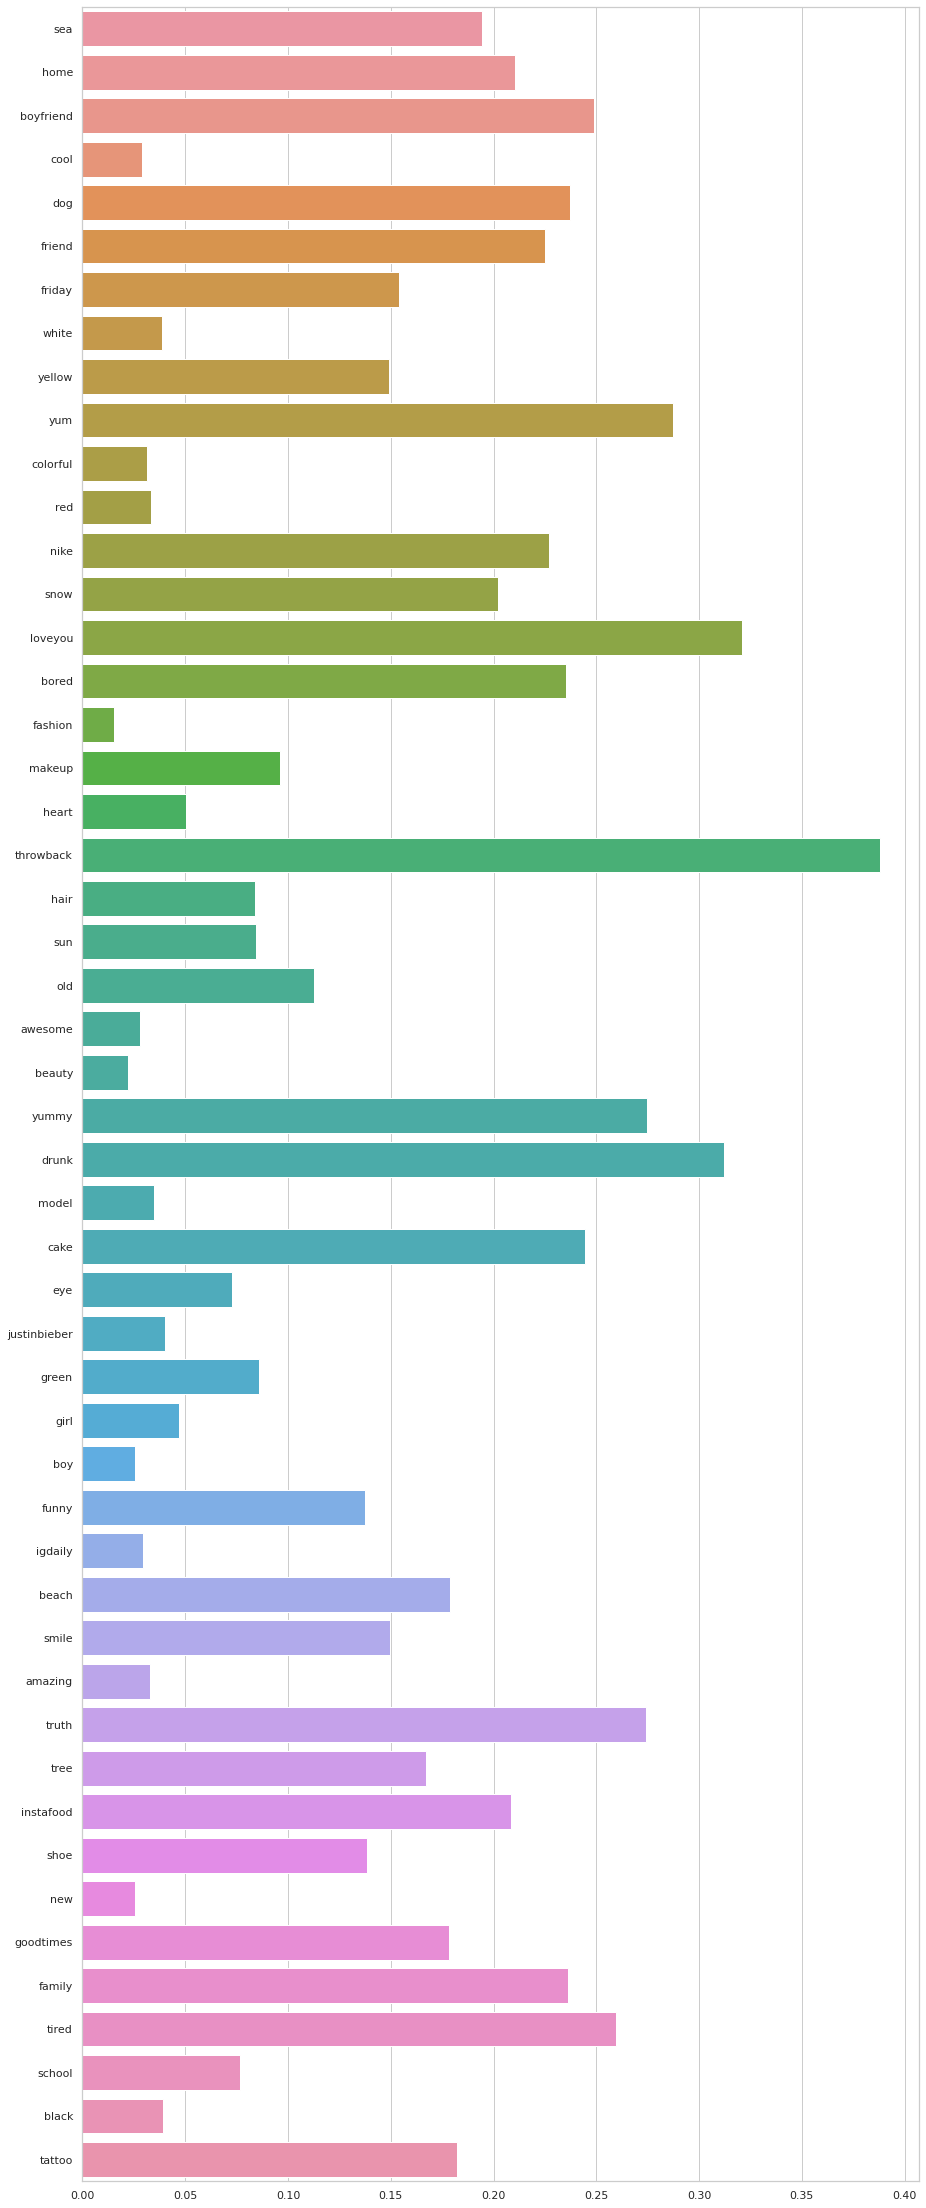

In [37]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,40))
sns.set(style="whitegrid")
ax = sns.barplot(x=list(recall_rates.values()), y=list(recall_rates.keys()))

In [38]:
loss, result_list = cal_hamming_loss(knn_list, test_tag_list)
print('Hamming loss (lower is better): %s' % loss)

Hamming loss (lower is better): 0.8406556093967611


In [39]:
import zipfile
locfile = "./predict_4.csv"
loczip = "./predict_4.zip"
zip = zipfile.ZipFile(loczip, "w", zipfile.ZIP_DEFLATED)
zip.write(locfile)
zip.close()

FileNotFoundError: [Errno 2] No such file or directory: './predict_4.csv'

In [40]:
from IPython.display import HTML
def create_download_link(title = "Ashish zip file", filename = "predict.zip"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe which was saved with .to_csv method
create_download_link(filename='predict.zip')